In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.getcwd()

'/content'

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [13]:
path = '/content/drive/MyDrive/DSL session/22-2/[0804] Supervised_learning/'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
os.chdir(path)

In [14]:
os.getcwd()

'/content/drive/MyDrive/DSL session/22-2/[0804] Supervised_learning'

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [6]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [7]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [8]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [15]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [ ]:
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!
# train_x =

In [22]:
data = pd.concat([train_x,train_y],axis=1)
data

,Temp,Wind,Moisture,Precipitation,Sun,Wh
0,17.6,2.5,92.0,0.8,0.0,8179.056
1,17.7,2.9,91.0,0.3,0.0,8135.640
2,17.5,3.2,91.0,0.0,0.0,8107.128
3,17.1,3.2,91.0,0.0,0.0,8048.808
4,17.0,3.3,92.0,0.0,0.0,8043.624
...,...,...,...,...,...,...
83,23.9,2.8,68.0,0.0,0.6,8386.416
84,25.0,3.1,63.0,0.0,0.8,8435.664
85,26.0,3.1,60.0,0.0,1.0,8591.184
86,26.4,3.8,60.0,0.0,1.0,8638.488


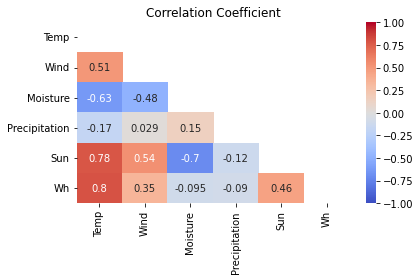

In [23]:
import seaborn as sns  
upp_mat = np.triu(data.corr())

sns.heatmap(data.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)
plt.title('Correlation Coefficient')
plt.tight_layout()
plt.show()

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : 전력 사용량(Wh)과 기온(Temp)의 상관관계가 가장 높음 -> 기온을 feature로 지정

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [31]:
# 사용할 패키지를 import!
from sklearn.preprocessing import StandardScaler

In [68]:
# input 데이터는 X_train, target 데이터는 Y_train 변수에 할당
X_train = train_x.iloc[:, 0].to_numpy()[:, np.newaxis]
Y_train = train_y.to_numpy()

In [69]:
X_train.shape

(88, 1)

In [72]:
# 데이터 scaling 하기
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_train

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [32]:
# 사용할 패키지를 import!
from sklearn.linear_model import LinearRegression

In [73]:
# 선형회귀 모델 생성 후 fitting 
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [34]:
esti_y = model.predict(X_train)

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [74]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [75]:
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 14543.75828


In [76]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

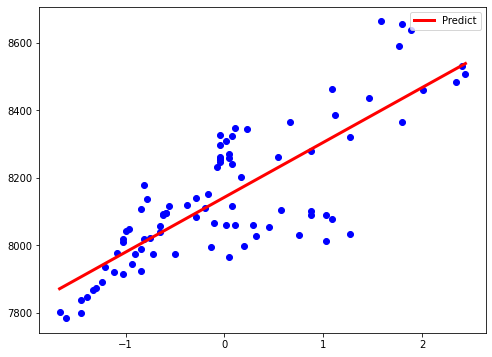

In [77]:
# visualization 하실 분은 진행해주세요!
visualize(model, X_train, Y_train)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [78]:
X_test = test_x.iloc[:, 0].to_numpy()[:, np.newaxis]
Y_test = test_y.to_numpy()

In [79]:
X_test = scaler.fit_transform(X_test)

In [80]:
# pred_y에 predict값 할당
pred_y = model.predict(X_test)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [81]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [82]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 248505.17676


In [83]:
score(train_mse,test_mse)

 17.0867


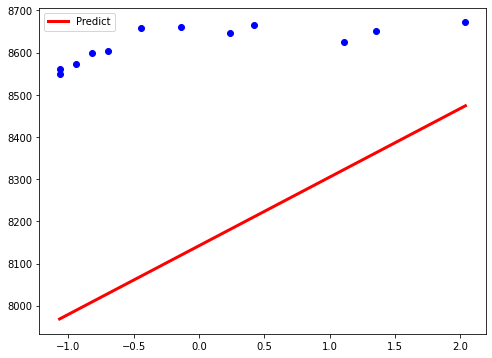

In [84]:
# visualization 하실 분은 진행해주세요!
visualize(model, X_test, Y_test)

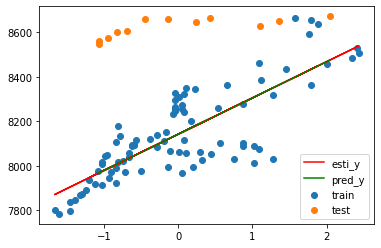

In [85]:
# visualization2
plt.scatter(X_train[:, 0], Y_train, label='train')
plt.scatter(X_test[:, 0], Y_test, label='test')

plt.plot(X_train[:, 0], 
         model.predict(X_train), 
         c='r', label='esti_y')
plt.plot(X_test[:, 0], 
         pred_y, 
         c='g', label='pred_y')

plt.legend();

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

In [56]:
# 관련 모듈 import
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

In [57]:
# 파이프라인 생성
p1 = Pipeline([
               ('poly', PolynomialFeatures(degree=5, include_bias=False)),
               ('scaler', StandardScaler()),
               ('rdg_reg_1', Ridge(alpha=0.5))
])

In [58]:
p1.fit(X_train, Y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=5, include_bias=False)),
                ('scaler', StandardScaler()), ('rdg_reg_1', Ridge(alpha=0.5))])

In [87]:
mse(p1.predict(X_train), Y_train)

11764.071202178207

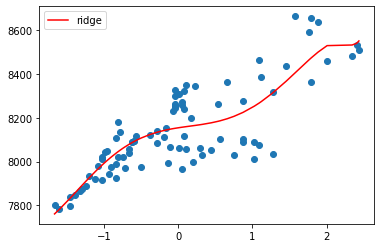

In [60]:
#degree=5, alpha=0.5 적용하였을 경우
plt.scatter(X_train[:, 0], Y_train)
plt.plot(np.sort(X_train[:, 0]), 
         np.sort(p1.predict(X_train)), 
         c='r', label='ridge')
plt.legend();

고생하셨습니다!